In [1]:
import matplotlib as mpl
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
    ]),
})

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import pickle
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import scienceplots

plt.style.use(["science", "no-latex"])

In [2]:
max_dim = 25

In [3]:
pruning_config_hashes = {
    "none": "fdda88f15729a5f42b5c1dd5e2f95aaf",
    "each-operation": "374102aefbd5748a5ac334ca9be92bd1",
    "each-step": "048896136dd1358b8ce8269be3283ff4",
    "on-finish": "73c4344e9c575c9f83c4d7f6eaca3cf1",
}

In [4]:
target_labels = {
    "postgres": "DuBio (Temp. Table)",
    "postgres_inmemory": "DuBio (In Mem.)",
    "databricks": "Doubtless"
}

def get_target_label(target):
    return target_labels[target]

In [5]:
targets = ["postgres", "postgres_inmemory", "databricks"]
experiments = ["count", "sum", "avg", "min", "max"]

experiment_results = {}

for target in targets:
    experiment_results[target] = {}
    for experiment in experiments:
        experiment_results[target][experiment] = {}
        for prune_method, hashname in pruning_config_hashes.items():
            execution_times = np.load(
                f"../experiment_results/{target}/{experiment}/{hashname}/execution_times.npy",
                allow_pickle=True
            )
            experiment_results[target][experiment][prune_method] = execution_times

experiment_results

{'postgres': {'count': {'none': array([[1.54678000e-01, 1.53300000e-01, 1.46184000e-01, 1.38739000e-01,
           1.34067000e-01, 1.31638000e-01, 1.47967000e-01, 1.38192000e-01,
           1.36715000e-01, 1.36705000e-01, 1.42153000e-01, 1.38421000e-01,
           1.43950000e-01, 1.41132000e-01],
          [1.33836000e-01, 1.44935000e-01, 1.51434000e-01, 1.45629000e-01,
           1.37951000e-01, 1.74896000e-01, 1.59652000e-01, 1.58331000e-01,
           1.69625000e-01, 1.72192000e-01, 1.79192000e-01, 1.92259000e-01,
           2.33176000e-01, 2.23376000e-01],
          [1.53016000e-01, 1.52723000e-01, 1.63935000e-01, 1.51710000e-01,
           1.46765000e-01, 1.59282000e-01, 1.70152000e-01, 1.94496000e-01,
           2.10844000e-01, 2.55532000e-01, 3.10299000e-01, 5.80339000e-01,
           5.13284000e-01, 8.50549000e-01],
          [1.36086000e-01, 1.37311000e-01, 1.38905000e-01, 1.46638000e-01,
           1.56369000e-01, 1.91932000e-01, 2.25833000e-01, 2.71835000e-01,
           5.9

## Combined Line Plots

In [6]:
def draw_scatter(ax, execution_times, prune_method):
    xrange = np.arange(1, execution_times.shape[0] + 1)
    yrange = np.arange(1, execution_times.shape[1] + 1)

    X, Y = np.meshgrid(xrange, yrange)
    world_counts = (Y ** X).flatten()
    flat_execution_times = execution_times.flatten()
    areas = Y.flatten() ** 2

    ax.set_title(f"{target}\n{experiment}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.scatter(world_counts, flat_execution_times, s=areas, label=prune_method)

def draw_lines(ax, execution_times, prune_method):
    xrange = np.arange(1, execution_times.shape[0] + 1)
    
    ax.set_title(f"{target}\n{experiment}")
    ax.set_xscale("log")
    ax.set_yscale("log")

    color = None
    for i, times in enumerate(execution_times):
        alternatives = i + 1
        world_counts = alternatives ** xrange

        kwargs = {
            "alpha": 0.8,
        }

        if i == 0:
            line, = ax.plot(world_counts, times, label=prune_method, **kwargs)
            color = line.get_color()
        else:
             ax.plot(world_counts, times, color=color, **kwargs)


def draw_avg_banded(ax, execution_times, prune_method,
               sigma=1.5, num_points=150):
    """
    Parameters
    ----------
    sigma: float
        Standard deviation (in grid-point units) for Gaussian smoothing of the
        **mean** line. 0 = no smoothing.
    num_points : int
        Resolution of the common x-grid.
    """
    # ------------------------------------------------------------------ #
    # 1. Collect (x, y) pairs for every individual run
    # ------------------------------------------------------------------ #
    data = []
    for i, times in enumerate(execution_times):
        times = np.asarray(times)
        alternatives = i + 1
        xrange = np.arange(1, len(times) + 1)
        world_counts = alternatives ** xrange
        data.append((world_counts, times))

    if not data:
        return

    # ------------------------------------------------------------------ #
    # 2. Common x-grid (log-spaced because world_counts grow exponentially)
    # ------------------------------------------------------------------ #
    all_x = np.concatenate([x for x, _ in data])
    x_min, x_max = all_x.min(), all_x.max()
    if x_min <= 0 or x_min == x_max:
        x_grid = np.linspace(x_min, x_max, num_points)
    else:
        x_grid = np.logspace(np.log10(x_min), np.log10(x_max), num_points)

    # ------------------------------------------------------------------ #
    # 3. Interpolate every run onto the grid (linear, no extrapolation)
    # ------------------------------------------------------------------ #
    interps = [
        interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
        for x, y in data
    ]
    y_grid = np.array([f(x_grid) for f in interps])   # (n_runs, n_grid)

    # ------------------------------------------------------------------ #
    # 4. Statistics (ignore NaNs)
    # ------------------------------------------------------------------ #
    # y_mean = np.nanmean(y_grid, axis=0)
    y_mean = np.power(10, np.nanmean(np.log10(y_grid), axis=0))
    # y_mean = np.exp(np.nanmean(np.log(y_grid), axis=0))
    y_lower = np.nanpercentile(y_grid, 10, axis=0)
    y_upper = np.nanpercentile(y_grid, 90, axis=0)

    # ------------------------------------------------------------------ #
    # 5. SMOOTHING
    # ------------------------------------------------------------------ #
    if sigma > 0:
        y_mean = gaussian_filter1d(y_mean, sigma=sigma, mode='nearest')
        y_lower = gaussian_filter1d(y_lower, sigma=sigma * 0.8, mode='nearest')
        y_upper = gaussian_filter1d(y_upper, sigma=sigma * 0.8, mode='nearest')

    # ------------------------------------------------------------------ #
    # 6. Plot
    # ------------------------------------------------------------------ #
    line, = ax.plot(x_grid, y_mean, label=prune_method)
    color = line.get_color()
    ax.fill_between(x_grid, y_lower, y_upper, color=color, alpha=0.25)

    max_not_nan_index = (~np.isnan(y_mean)).cumsum(0).argmax(0)
    size = y_mean.shape[0]
    if max_not_nan_index != size - 1:
        # Experiments were aborted due to timeout, add an X
        ax.plot(x_grid[max_not_nan_index], y_mean[max_not_nan_index], "-x", color=color)

    ax.set_title(f"{experiment.upper()} Aggregation")   # keep your original title
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Possible Worlds")
    ax.set_ylabel("Query Time")

In [7]:
def draw_timeout(ax, resize=True):
    ax.axhline(15*60, linestyle=(0, (1, 3)), color="black")
    ax.text(0.02, 15*60 * 1.15, "Timeout", ha="left", va="bottom", transform=ax.get_yaxis_transform())

    if resize:
        ylim_bottom, ylim_top = ax.get_ylim()
        ax.set_ylim(ylim_bottom, 15*60 * 5)

def draw_legend(ax, name, resize=True):
    ax.legend(title=name, loc="lower right")

    if resize:
        xlim_left, xlim_right = ax.get_xlim()
        ax.set_xlim(xlim_left, xlim_right * 10)

/tmp/ipykernel_1209303/1979520302.py:86: RuntimeWarning: Mean of empty slice
  y_mean = np.power(10, np.nanmean(np.log10(y_grid), axis=0))


postgres


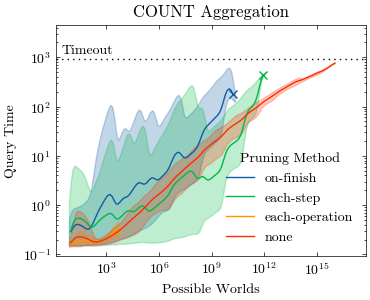

postgres


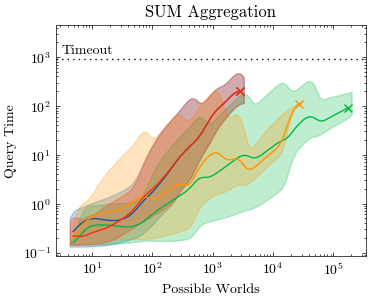

postgres


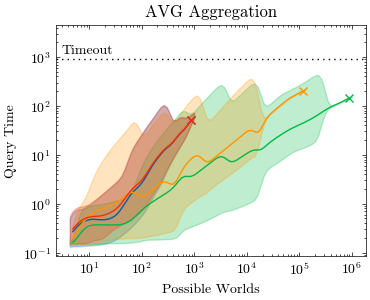

postgres


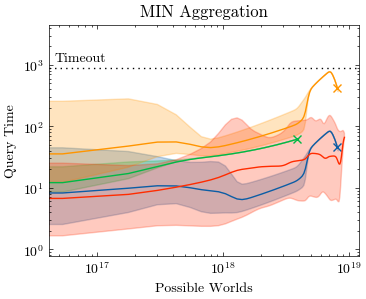

postgres


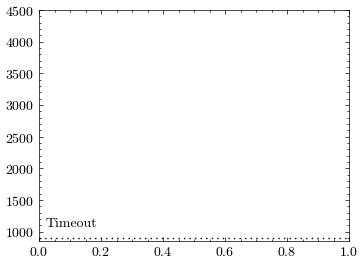

postgres_inmemory


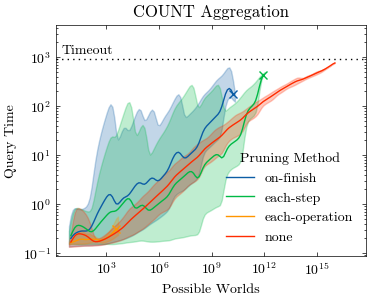

postgres_inmemory


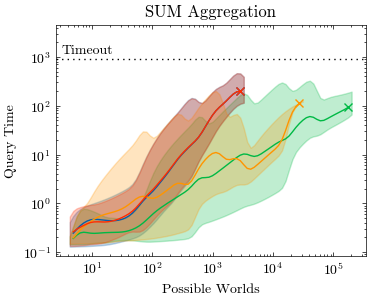

postgres_inmemory


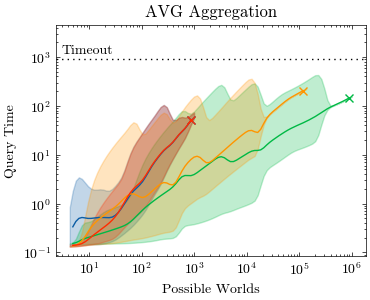

postgres_inmemory


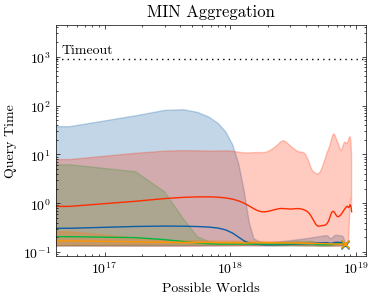

postgres_inmemory


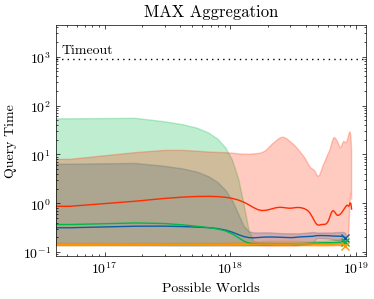

databricks


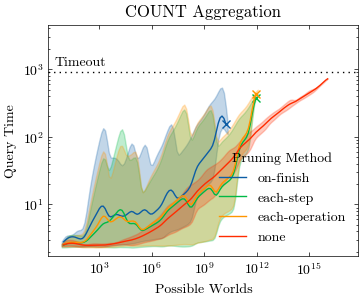

databricks


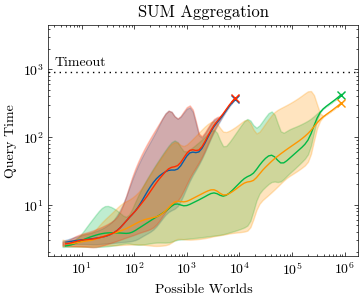

databricks


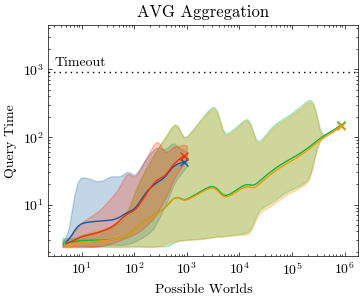

databricks


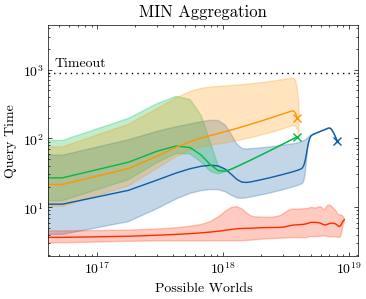

databricks


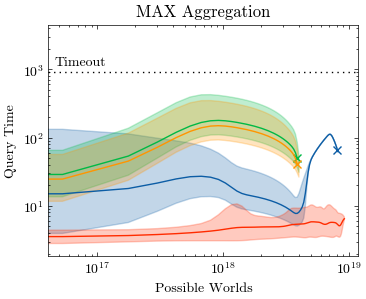

<Figure size 350x262.5 with 0 Axes>

In [14]:
%matplotlib inline

for target in targets:
    for i, experiment in enumerate(experiments):
        plt.tight_layout()
        fig, ax = plt.subplots(figsize=(4,3))
        for prune_method in reversed(list(pruning_config_hashes.keys())):
            # if prune_method != "none":
            #     continue
            execution_times = np.array(
                experiment_results[target][experiment][prune_method],
                dtype=float
            )[0:max_dim, 0:max_dim]

            if np.all(np.isnan(execution_times)):
                continue

            # draw_scatter(ax, execution_times, prune_method)
            # draw_lines(ax, execution_times, prune_method)
            draw_avg_banded(ax, execution_times, prune_method)
            
        draw_timeout(ax)
        if i == 0:
            draw_legend(ax, "Pruning Method")
        
        print(target)
        display(fig)
        plt.savefig(f"../figures/agg_scatter_{target}_{experiment}.pgf", bbox_inches="tight")
        plt.close()

## Individual 3D Plots

postgres


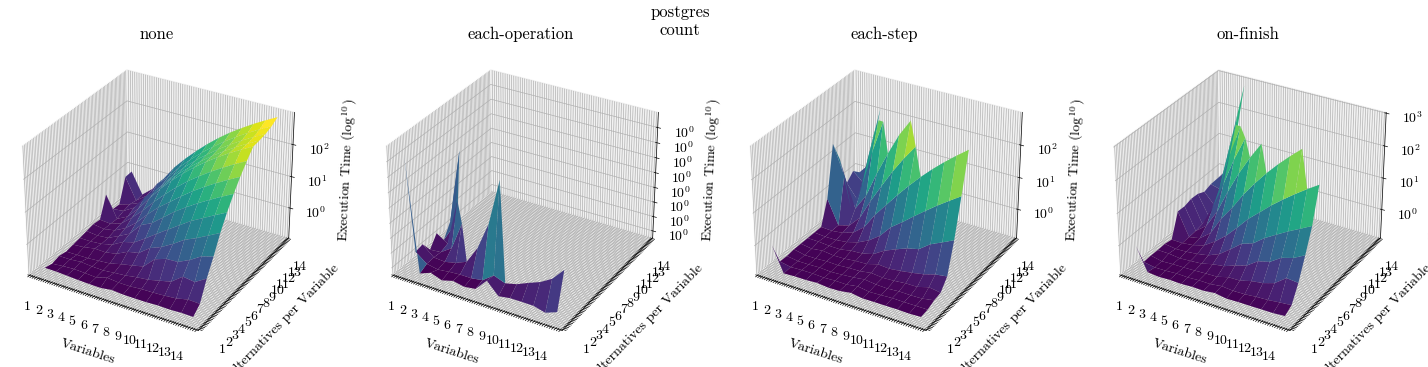

postgres


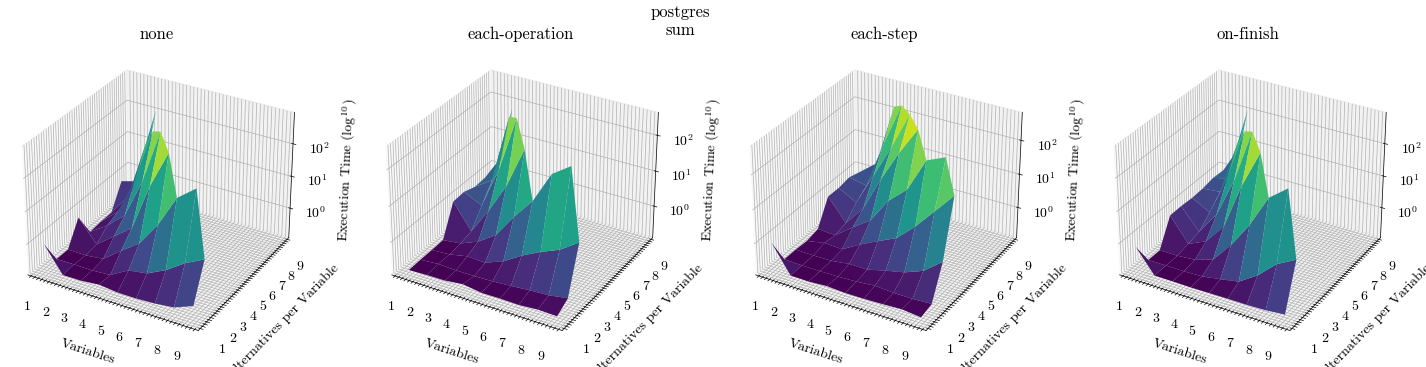

postgres


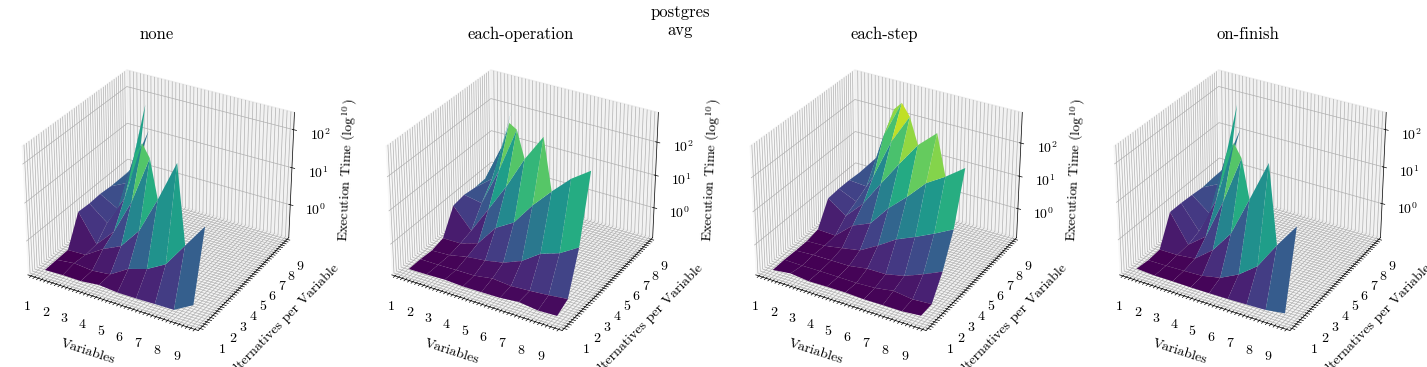

postgres


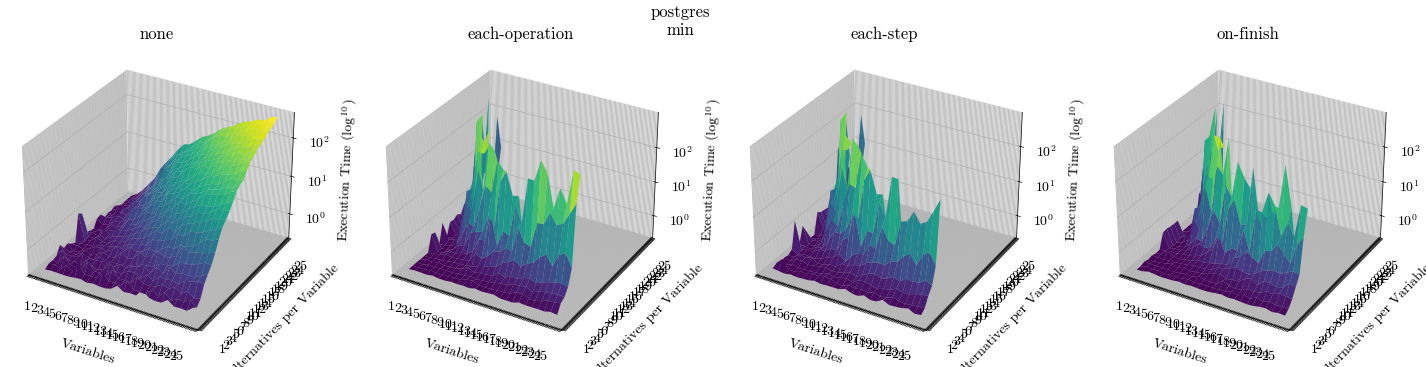

postgres


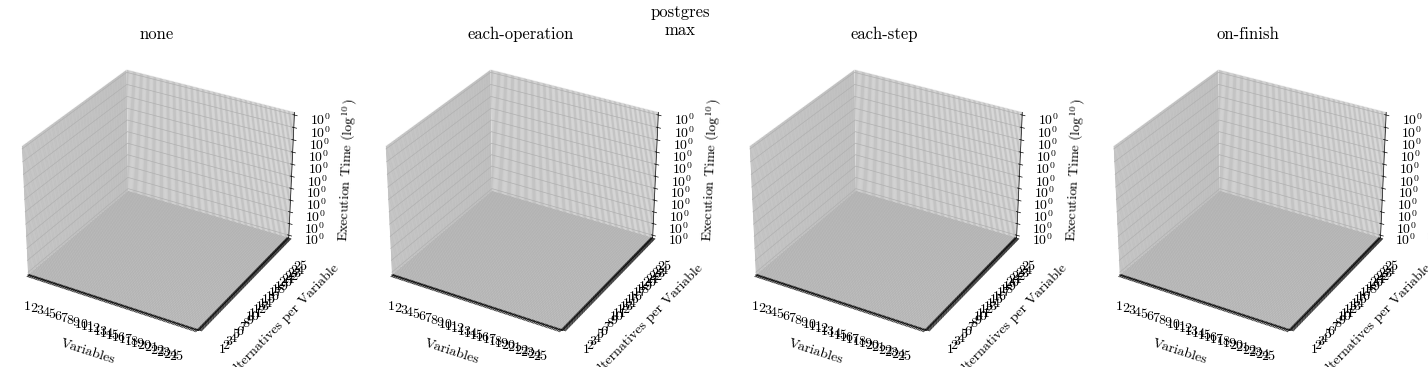

postgres_inmemory


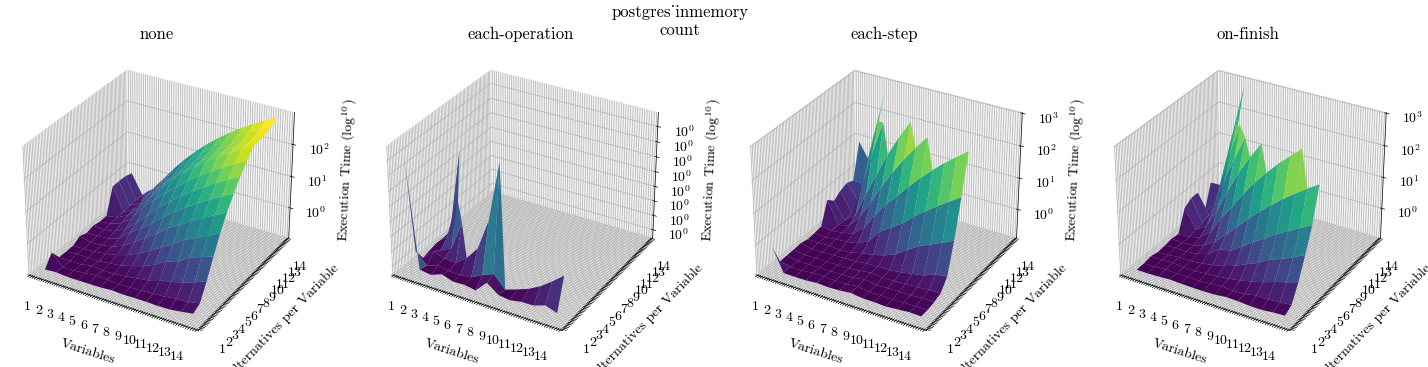

postgres_inmemory


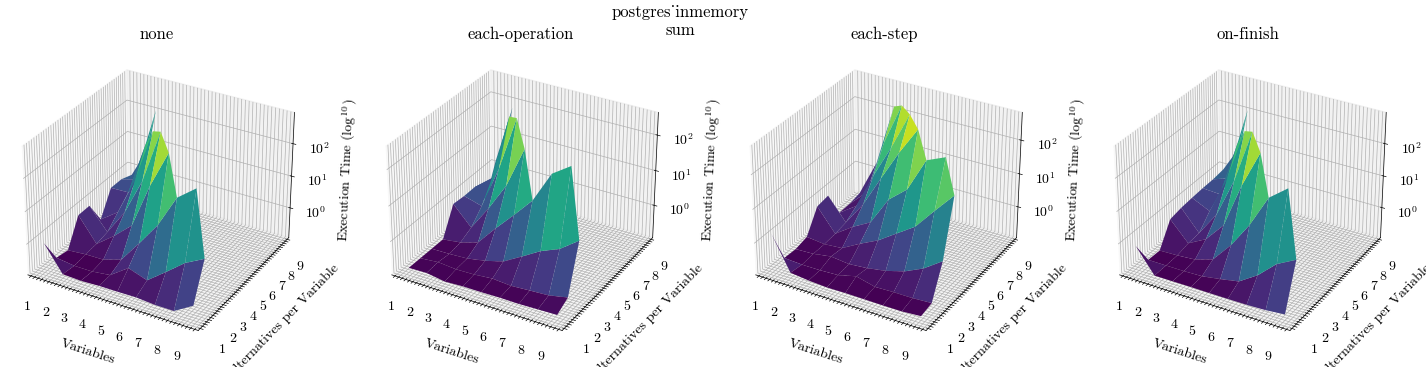

postgres_inmemory


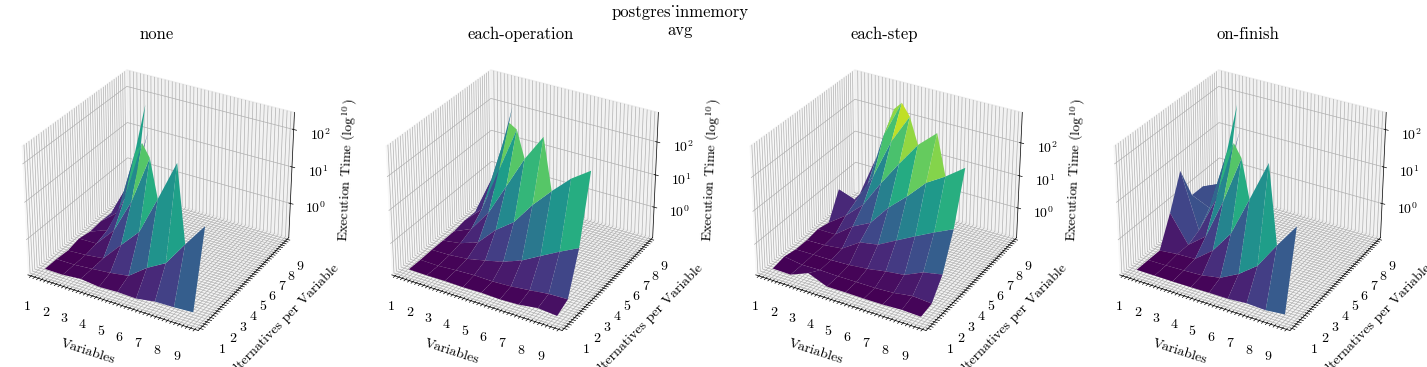

postgres_inmemory


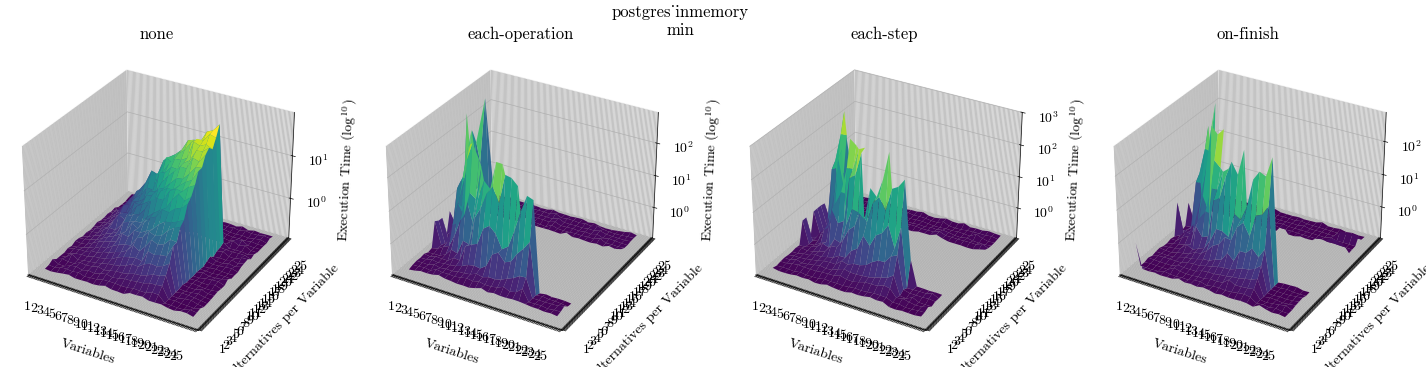

postgres_inmemory


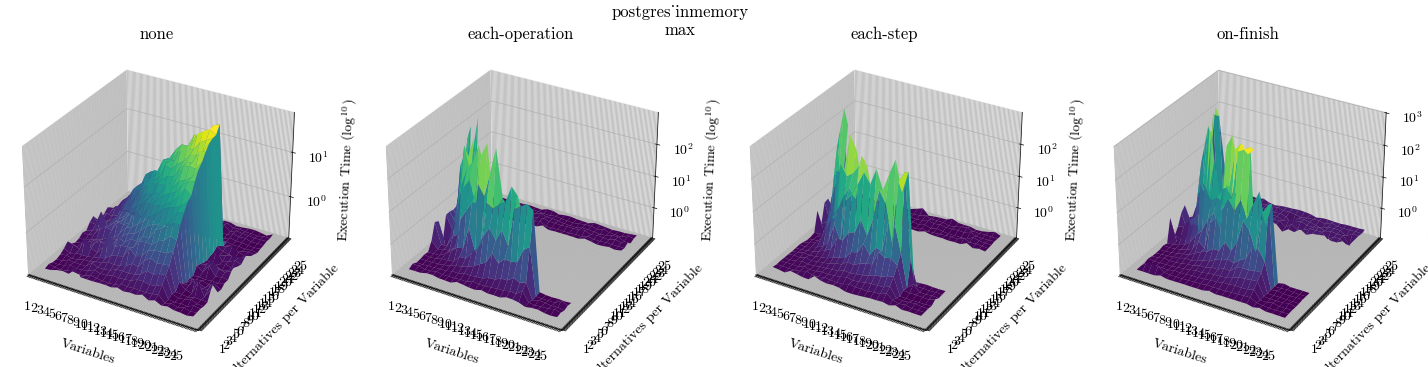

databricks


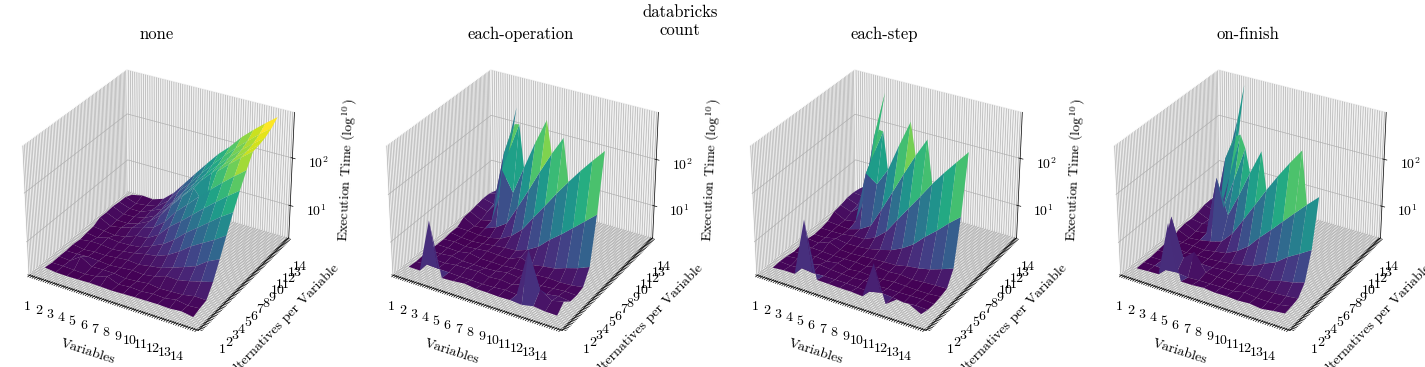

databricks


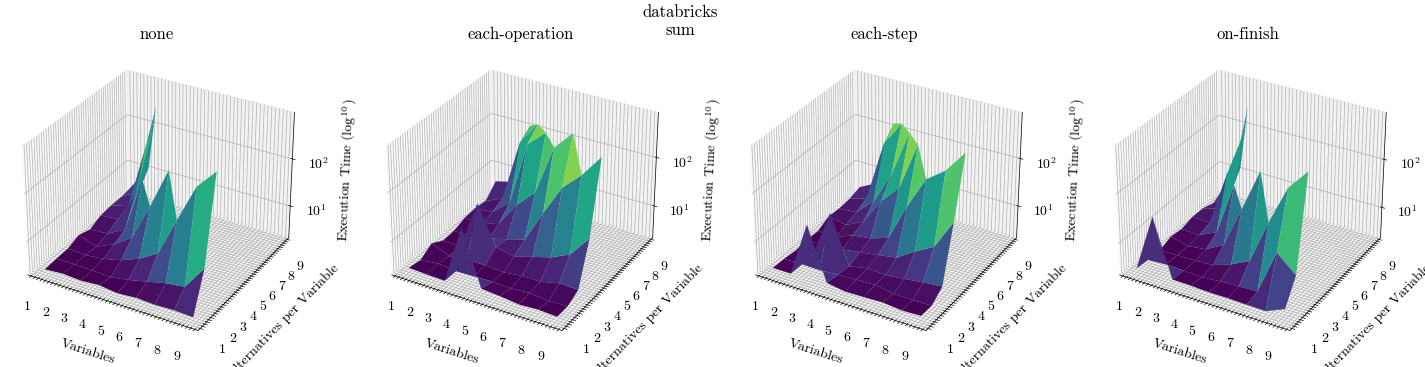

databricks


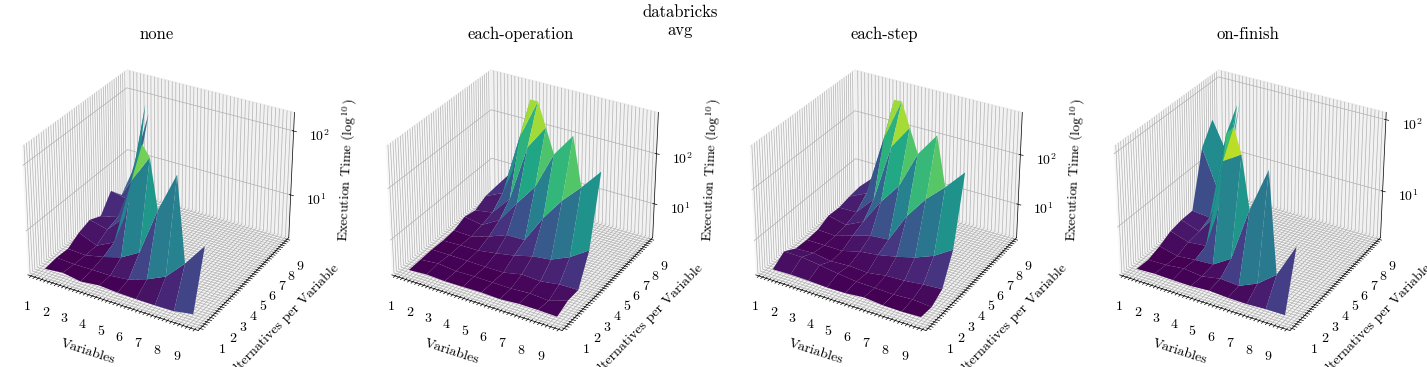

databricks


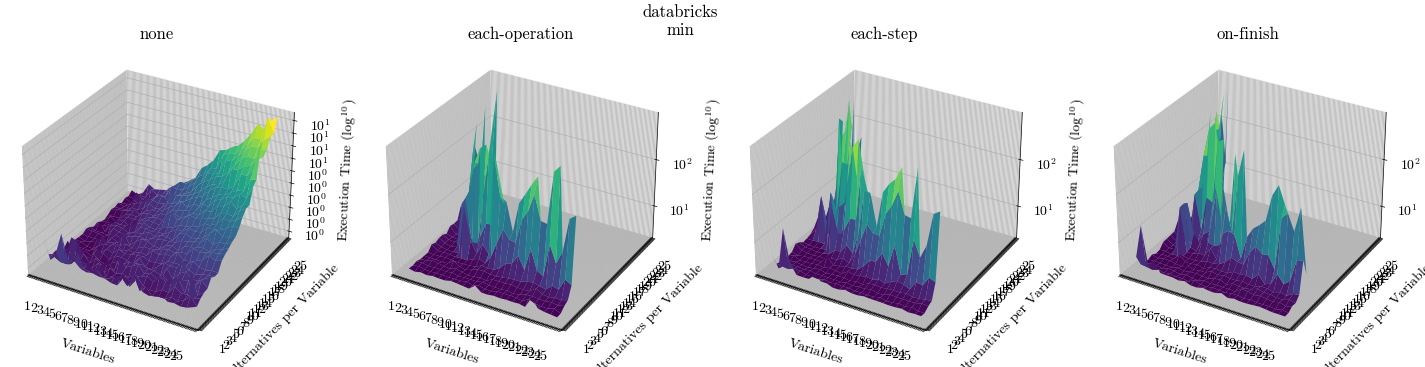

databricks


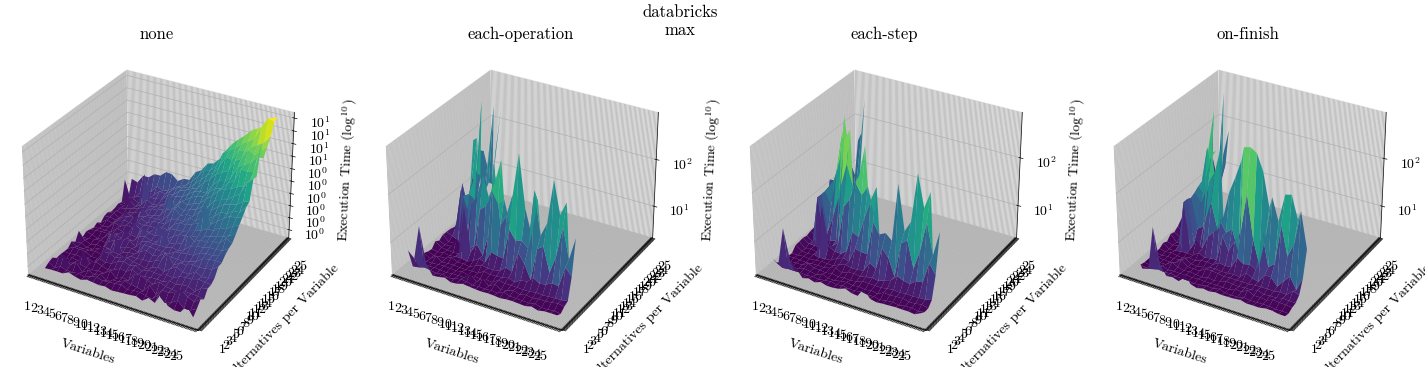

In [10]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

for target in targets:
    for experiment in experiments:
        fig, axs = plt.subplots(
            nrows=1,
            ncols=4,
            figsize=(18,4),
            subplot_kw=dict(projection="3d")
        )
        fig.suptitle(f"{target}\n{experiment}")
        for i, prune_method in enumerate(pruning_config_hashes.keys()):
            execution_times = np.array(
                experiment_results[target][experiment][prune_method],
                dtype=float
            )[0:max_dim, 0:max_dim]

            ax = axs[i]
            
            xrange = np.arange(1, execution_times.shape[0] + 1)
            yrange = np.arange(1, execution_times.shape[1] + 1)
    
            X, Y = np.meshgrid(xrange, yrange)
            
            ax.set_title(prune_method)
            ax.plot_surface(X, Y, np.log10(execution_times), cmap="viridis")
    
            ax.set_xlabel("Variables")
            ax.set_ylabel("Alternatives per Variable")
            ax.set_zlabel("Execution Time ($\\log^{10}$)")
    
            ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
            ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    
            ax.set_xticks(xrange, [f"{x}" for x in xrange])
            ax.set_yticks(yrange, [f"{y}" for y in yrange])

        print(target)
        display(fig)
        plt.close()

## Comparison Line Plots

In [11]:
def draw_avg_comparison(ax, execution_times, system, sigma=1.5, num_points=150):
    """
    Parameters
    ----------
    sigma: float
        Standard deviation (in grid-point units) for Gaussian smoothing of the
        **mean** line. 0 = no smoothing.
    num_points : int
        Resolution of the common x-grid.
    """
    # ------------------------------------------------------------------ #
    # 1. Collect (x, y) pairs for every individual run
    # ------------------------------------------------------------------ #
    data = []
    for i, times in enumerate(execution_times):
        times = np.asarray(times)
        alternatives = i + 1
        xrange = np.arange(1, len(times) + 1)
        world_counts = alternatives ** xrange
        data.append((world_counts, times))

    if not data:
        return

    # ------------------------------------------------------------------ #
    # 2. Common x-grid (log-spaced because world_counts grow exponentially)
    # ------------------------------------------------------------------ #
    all_x = np.concatenate([x for x, _ in data])
    x_min, x_max = all_x.min(), all_x.max()
    if x_min <= 0 or x_min == x_max:
        x_grid = np.linspace(x_min, x_max, num_points)
    else:
        x_grid = np.logspace(np.log10(x_min), np.log10(x_max), num_points)

    # ------------------------------------------------------------------ #
    # 3. Interpolate every run onto the grid (linear, no extrapolation)
    # ------------------------------------------------------------------ #
    interps = [
        interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
        for x, y in data
    ]
    y_grid = np.array([f(x_grid) for f in interps])   # (n_runs, n_grid)

    # ------------------------------------------------------------------ #
    # 4. Statistics (ignore NaNs)
    # ------------------------------------------------------------------ #
    # y_mean = np.nanmean(y_grid, axis=0)
    y_mean = np.power(10, np.nanmean(np.log10(y_grid), axis=0))
    # y_mean = np.exp(np.nanmean(np.log(y_grid), axis=0))

    # ------------------------------------------------------------------ #
    # 5. SMOOTHING
    # ------------------------------------------------------------------ #
    if sigma > 0:
        y_mean = gaussian_filter1d(y_mean, sigma=sigma, mode='nearest')

    # ------------------------------------------------------------------ #
    # 6. Plot
    # ------------------------------------------------------------------ #
    line, = ax.plot(x_grid, y_mean, label=system)

    max_not_nan_index = (~np.isnan(y_mean)).cumsum(0).argmax(0)
    size = y_mean.shape[0]
    if max_not_nan_index != size - 1:
        # Experiments were aborted due to timeout, add an X
        ax.plot(x_grid[max_not_nan_index], y_mean[max_not_nan_index], "-x", color=line.get_color())

    ax.set_title(f"{experiment.upper()} Aggregation")   # keep your original title
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Possible Worlds")
    ax.set_ylabel("Query Time")

/tmp/ipykernel_1209303/484363222.py:48: RuntimeWarning: Mean of empty slice
  y_mean = np.power(10, np.nanmean(np.log10(y_grid), axis=0))


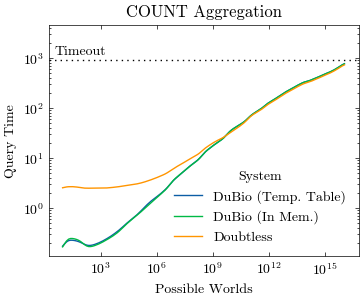

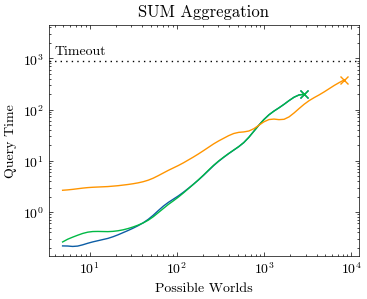

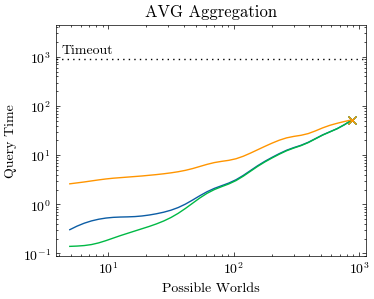

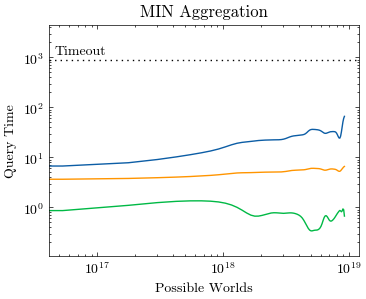

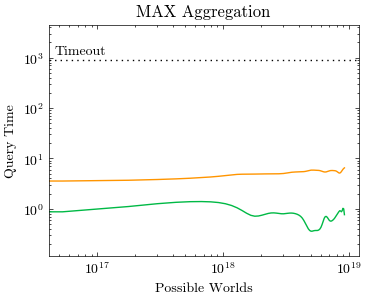

<Figure size 350x262.5 with 0 Axes>

In [12]:
%matplotlib inline

for i, experiment in enumerate(experiments):
    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(4,3))
    for target in targets:
        execution_times = np.array(
            experiment_results[target][experiment]["none"],
            dtype=float
        )[0:max_dim, 0:max_dim]

        draw_avg_comparison(ax, execution_times, get_target_label(target))
        
    draw_timeout(ax)
    if i == 0:
        draw_legend(ax, "System", resize=False)

    display(fig)
    plt.savefig(f"../figures/agg_line_comparison_{experiment}.pgf", bbox_inches="tight")
    plt.close()

## Variable Alternatives Each Step

In [16]:
mycmap = cm.viridis

def draw_lines_altmap(ax, execution_times, sigma=0.5):
    norm = plt.Normalize(vmin=1, vmax=execution_times.shape[0])
    
    ax.set_title(f"{experiment.upper()} Aggregation")
    ax.set_xscale("log")
    ax.set_yscale("log")

    color = None
    for i, times in enumerate(execution_times):
        xrange = np.arange(1, len(times) + 1)
        
        alternatives = i + 1
        world_counts = alternatives ** xrange

        if sigma > 0:
            times = gaussian_filter1d(times, sigma=sigma, mode='nearest')
            
        line, = ax.plot(world_counts, times, color=mycmap(norm(alternatives)))

        max_not_nan_index = (~np.isnan(times)).cumsum(0).argmax(0)
        size = times.shape[0]
        if max_not_nan_index != size - 1:
            # Experiments were aborted due to timeout, add an X
            ax.plot(world_counts[max_not_nan_index], times[max_not_nan_index], "-x", color=line.get_color())

        ax.set_xlabel("Possible Worlds")
        ax.set_ylabel("Query Time")

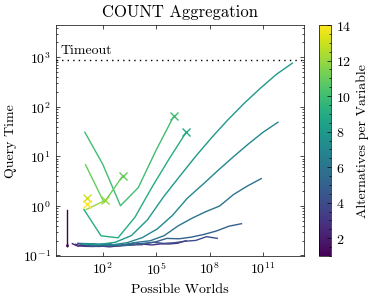

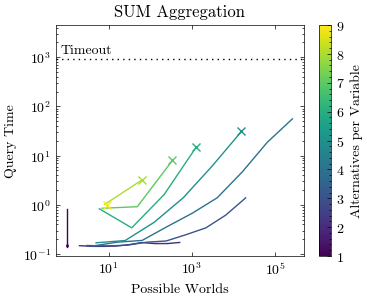

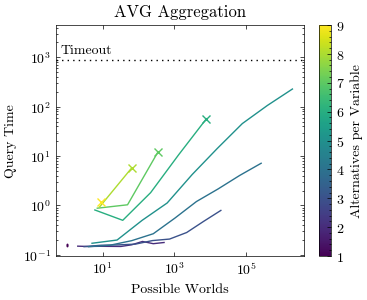

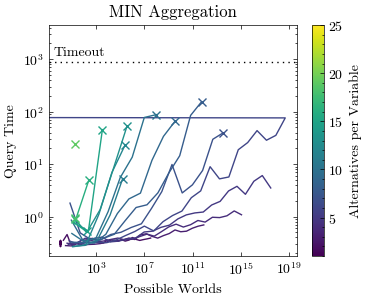

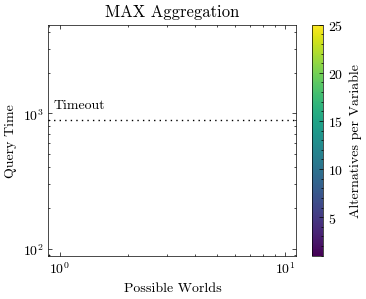

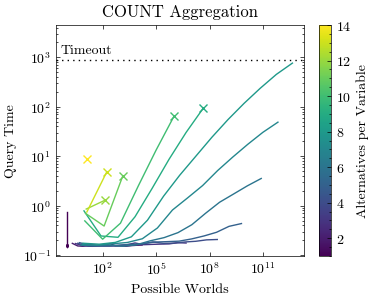

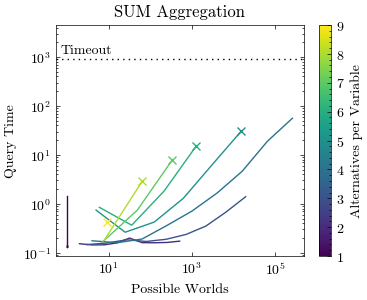

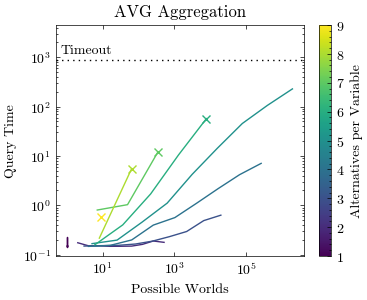

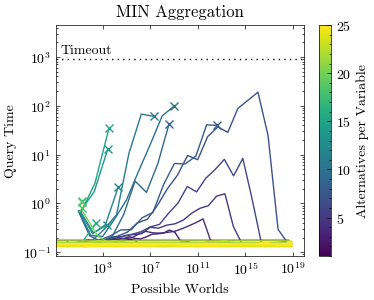

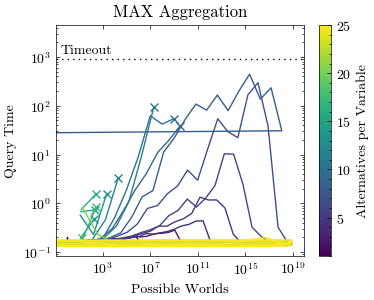

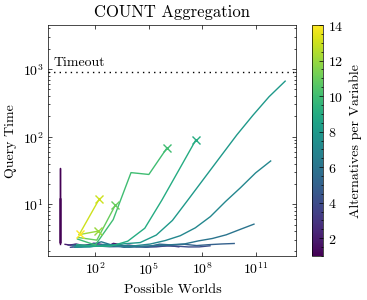

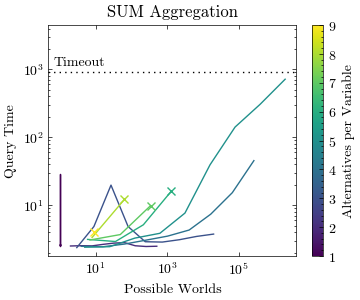

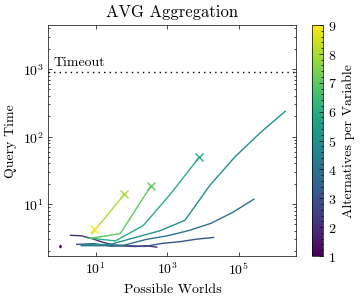

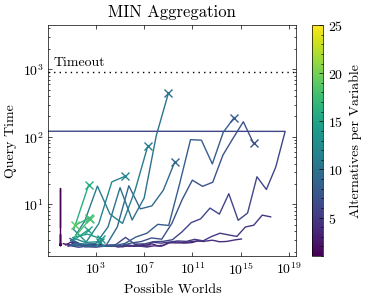

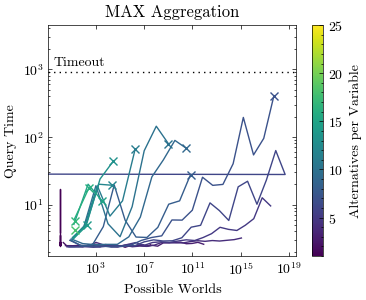

<Figure size 350x262.5 with 0 Axes>

In [17]:
for target in targets:
    for experiment in experiments:
        plt.tight_layout()
        fig, ax = plt.subplots(figsize=(4,3))
        
        execution_times = np.array(
            experiment_results[target][experiment]["each-step"],
            dtype=float
        )[0:max_dim, 0:max_dim]
    
        draw_lines_altmap(ax, execution_times)
        
        draw_timeout(ax)
    
        sm = plt.cm.ScalarMappable(cmap=mycmap, norm=plt.Normalize(vmin=1, vmax=execution_times.shape[0]))
        fig.colorbar(sm, ax=ax, label="Alternatives per Variable")
    
        display(fig)
        plt.savefig(f"../figures/agg_line_alternatives_{target}_{experiment}.pgf", bbox_inches="tight")
        plt.close()

## System Comparison Table

In [219]:
rows = []

for experiment in experiments:
    for target in targets:
        execution_times = np.array(
            experiment_results[target][experiment]["none"],
            dtype=float
        )[0:max_dim, 0:max_dim]

        max_world_count = None
        max_world_count_time = None
        for i, times in enumerate(execution_times):
            times = np.asarray(times)
            alternatives = i + 1
            xrange = np.arange(1, len(times) + 1)
            
            world_counts = alternatives ** xrange
            non_nan_world_counts = world_counts[~np.isnan(times)]
            if len(non_nan_world_counts) == 0:
                continue
            
            non_nan_times = times[~np.isnan(times)]
            max_non_nan_world_count = np.max(non_nan_world_counts)
            max_time_index = np.argmax(non_nan_world_counts)
            max_time = non_nan_times[max_time_index]

            if max_world_count == max_non_nan_world_count and max_time < max_world_count_time:
                max_world_count_time = max_time
            elif max_world_count is None or max_non_nan_world_count > max_world_count:
                max_world_count = max_non_nan_world_count
                max_world_count_time = max_time

        rows.append({
            "Aggregation": experiment.upper(),
            "System": target,
            "Max Possible Worlds": max_world_count,
            "Query Time": max_world_count_time
        })

df = pd.DataFrame(rows)
display(df)
print(df.to_latex(
    index=False,
    formatters={
        "System": get_target_label,
        "Max Possible Worlds": lambda w: f"{w:.0f}"
    },
    float_format="{:.3f}".format
))

Aggregation             System  Max Possible Worlds  Query Time
0        COUNT           postgres         1.111201e+16  792.769803
1        COUNT  postgres_inmemory         1.111201e+16  791.186995
2        COUNT         databricks         1.111201e+16  752.665372
3          SUM           postgres         6.561000e+03  164.064409
4          SUM  postgres_inmemory         6.561000e+03  163.881984
5          SUM         databricks         1.968300e+04  796.972442
6          AVG           postgres         2.187000e+03  207.793263
7          AVG  postgres_inmemory         2.187000e+03  208.057185
8          AVG         databricks         2.187000e+03  108.035155
9          MIN           postgres         9.205575e+18   70.828569
10         MIN  postgres_inmemory         9.205575e+18    0.144910
11         MIN         databricks         9.205575e+18    6.757659
12         MAX           postgres                  NaN         NaN
13         MAX  postgres_inmemory         9.205575e+18    0.202810
14         MAX         databricks         9.205575e+18    6.670263

\begin{tabular}{llrr}
\toprule
Aggregation & System & Max Possible Worlds & Query Time \\
\midrule
COUNT & DuBio (Temp. Table) & 11112006825558016 & 792.770 \\
COUNT & DuBio (In Mem.) & 11112006825558016 & 791.187 \\
COUNT & Doubtless & 11112006825558016 & 752.665 \\
SUM & DuBio (Temp. Table) & 6561 & 164.064 \\
SUM & DuBio (In Mem.) & 6561 & 163.882 \\
SUM & Doubtless & 19683 & 796.972 \\
AVG & DuBio (Temp. Table) & 2187 & 207.793 \\
AVG & DuBio (In Mem.) & 2187 & 208.057 \\
AVG & Doubtless & 2187 & 108.035 \\
MIN & DuBio (Temp. Table) & 9205575464528117760 & 70.829 \\
MIN & DuBio (In Mem.) & 9205575464528117760 & 0.145 \\
MIN & Doubtless & 9205575464528117760 & 6.758 \\
MAX & DuBio (Temp. Table) & NaN & NaN \\
MAX & DuBio (In Mem.) & 9205575464528117760 & 0.203 \\
MAX & Doubtless & 9205575464528117760 & 6.670 \\
\bottomrule
\end{tabular}

